# 00. Library Import

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import os
import cv2
from PIL import Image

# 01. Datasets load

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

# 02. Image preprocessing

In [4]:
# 이미지 정규화 및 리사이즈 함수
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 데이터셋에 정규화를 적용하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 03. Save Model Load

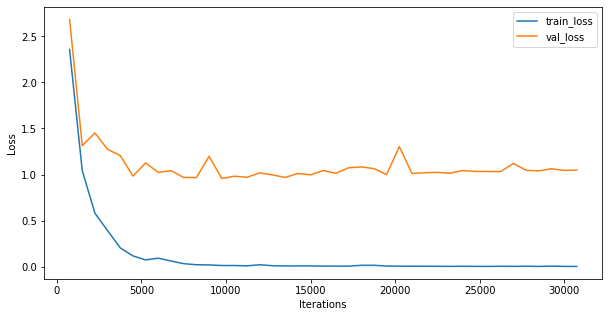
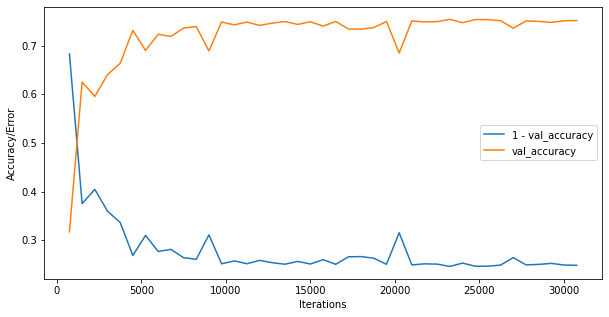

In [5]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/best_resnet50_aug.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

# 04. Class Activation Map function

### Sample 추출

In [6]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

### CAM 생성

In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0] 
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

### grad_CAM 생성

In [8]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### detection with CAM

In [9]:
def get_bbox(cam_image, score_thresh=0.2, kernel_size=(5, 5)):
    # 스무딩을 통해 더 부드러운 CAM 이미지 생성
    cam_image = cv2.GaussianBlur(cam_image, kernel_size, 0)
    
    # 임계값을 기준으로 필터링하여 관심 영역 강조
    low_indices = cam_image <= score_thresh
    cam_image[low_indices] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    # 외곽선 찾기
    contours, _ = cv2.findContours(cam_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return None

    # 가장 큰 외곽선 선택
    cnt = max(contours, key=cv2.contourArea)
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [10]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min() / float(image.shape[0]),  # y_min
        rect[:, 0].min() / float(image.shape[1]),  # x_min
        rect[:, 1].max() / float(image.shape[0]),  # y_max
        rect[:, 0].max() / float(image.shape[1])   # x_max
    ]
    return bbox

In [11]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

## Visualization image

In [12]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

### origin & blended Image

In [13]:
def visualize_cam(model, item, use_cam=True, activation_layer='conv5_block3_out'):
    item = copy.deepcopy(item)
    print(f"Label: {item['label']}")
    plt.imshow(item['image'])
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    if use_cam:
        cam_image = generate_cam(model, item)
        # CAM 시각화
        plt.imshow(cam_image, cmap='jet')
        plt.title('CAM')
        plt.axis('off')
        plt.show()
        
        # CAM 혼합 시각화
        cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)
        origin_image = item['image'].astype(np.uint8)
        blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
        
        plt.imshow(blended_image)
        plt.title('Blended CAM')
        plt.axis('off')
        plt.show()
        
        return cam_image
    else:
        grad_cam_image = generate_grad_cam(model, activation_layer, item)
        # Grad-CAM 시각화
        plt.imshow(grad_cam_image, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')
        plt.show()
        
        # Grad-CAM 혼합 시각화
        grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
        origin_image = item['image'].astype(np.uint8)
        blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
        
        plt.imshow(blended_image)
        plt.title('Blended Grad-CAM')
        plt.axis('off')
        plt.show()
        
        return None

### draw bbox

In [14]:
def draw_bbox(image, cam_image, score_thresh=0.2):
    rect = get_bbox(cam_image, score_thresh)
    if rect is None:
        print("No valid bounding box found.")
        return None
    
    pred_bbox = rect_to_minmax(rect, image)
    
    image_copy = copy.deepcopy(image)
    image_copy = cv2.drawContours(image_copy, [rect], 0, (0, 0, 255), 2)
    
    plt.imshow(image_copy)
    plt.title('Image with BBox')
    plt.axis('off')
    plt.show()
    
    return pred_bbox

### iou value

In [29]:
def visualize_with_iou(model, ds, use_cam=True, activation_layer='', score_thresh=0.05):
    item = get_one(ds)
    cam_image = visualize_cam(model, item, use_cam, activation_layer)
    
    if cam_image is not None:
        pred_bbox = draw_bbox(item['image'], cam_image, score_thresh)
        true_bbox = item['objects']['bbox'][0]
        iou_value = get_iou(pred_bbox, true_bbox)
        print(f"IoU CAM: {iou_value:.4f}")
        return iou_value
    elif not use_cam:
        grad_cam_image = generate_grad_cam(model, activation_layer, item)
        if grad_cam_image is not None:
            pred_bbox = draw_bbox(item['image'], grad_cam_image, score_thresh)
            true_bbox = item['objects']['bbox'][0]
            iou_value = get_iou(pred_bbox, true_bbox)
            print(f"IoU Grad-CAM: {iou_value:.4f}")
            return iou_value
    else:
        return None

# 05. Apply to image

### CAM result (label=84)

Label: 84


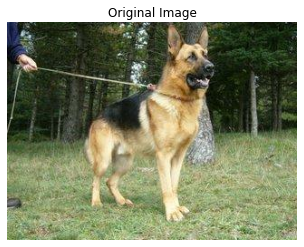

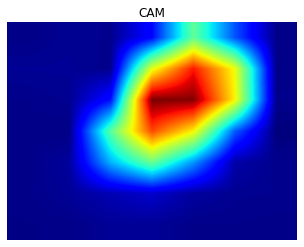

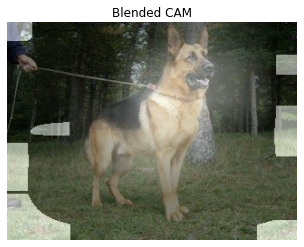

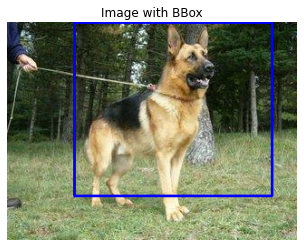

IoU between predicted bbox and true bbox: 0.6558


In [30]:
iou = visualize_with_iou(cam_model, ds_test, use_cam=True)

### CAM result (label=75)

Label: 75


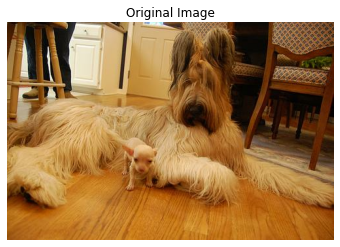

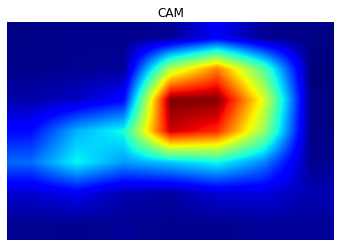

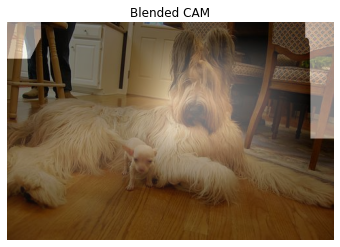

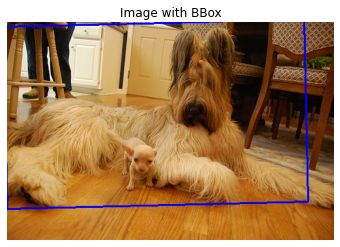

IoU between predicted bbox and true bbox: 0.8622


In [32]:
iou = visualize_with_iou(cam_model, ds_test, use_cam=True)

### CAM result (label=90)

Label: 90


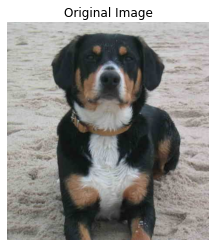

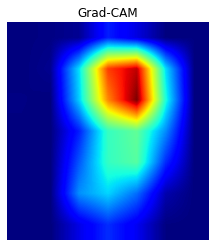

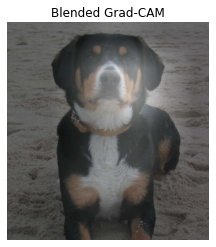

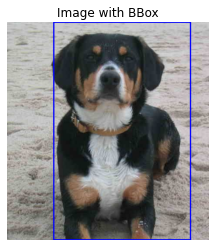

IoU between predicted bbox and true bbox (Grad-CAM): 0.8688


In [52]:
iou = visualize_with_iou(cam_model, ds_test, use_cam=False, activation_layer='conv5_block3_out')

### CAM & grad-CAM comparisonal result (label=75)

Label: 75


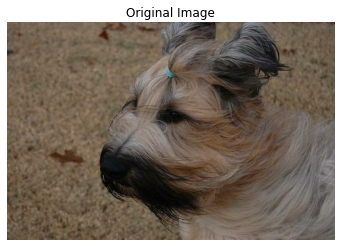

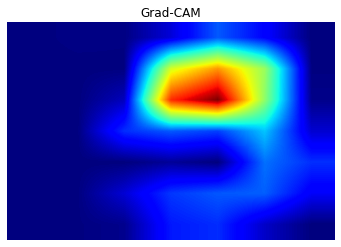

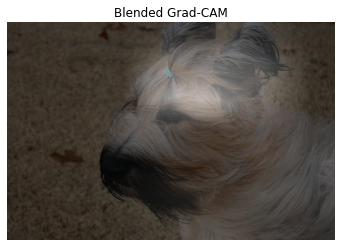

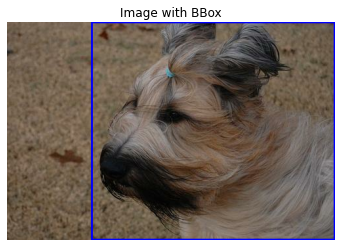

IoU between predicted bbox and true bbox (Grad-CAM): 0.9703


In [31]:
iou = visualize_with_iou(cam_model, ds_test, use_cam=False, activation_layer='conv5_block3_out')

Label: 75


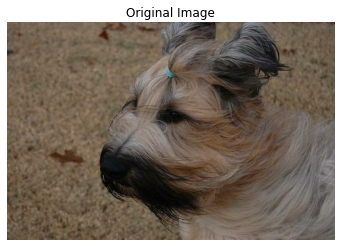

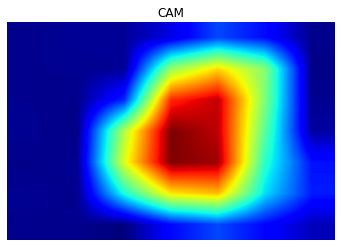

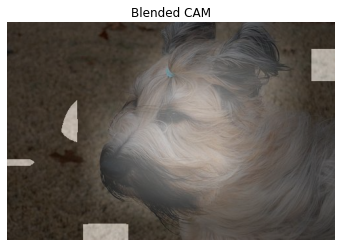

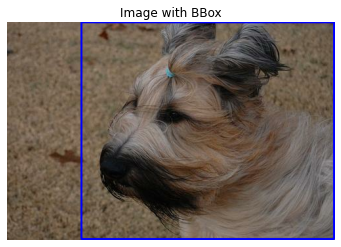

IoU between predicted bbox and true bbox: 0.9249


In [114]:
iou = visualize_with_iou(cam_model, ds_test, use_cam=True)

## 결과 분석
### CAM은 ResNet50의 output을 GAP을 통해 축소하고 Dense레이어와 연결하여 각 클래스에 해당하는 활성화 영역을 강조하는 방식이다. 따라서 GAP과 dense레이어로 고정되어 있어 모델의 활성화 영역에 대한 유연성이 다소 떨어질 수 있다. 
### 반면에 Grad_CAM은 지정한 레이어에 대한 gradient를 계산하고 이 가중치를 활용하여 클래스와 관련된 feature map을 강조하는 방식이다. 각 위치의 gradient를 평균화하여 feature map을 가중합하고 ReLU를 사용해 음수 값을 제거하므로 중요한 특징을 강조가 가능하다. 또한 CAM보다는 더 뚜렷한 경계와 중요 특징의 위치를 반영하는 결과 확인이 가능하다.
### 위 결과를 비교하여 보면 바운딩 박스를 통해 객체의 위치를 높은 정확도로 추출할 수 있음을 확인할 수 있으며, Grad_CAM이 iou값이 더 높은 경향을 나타냄을 확인 할 수 있었다. gradient를 통한 특징 강조가 유연성있는 Detection이 가능함을 알 수 있는 결과이다.

## 고찰
### CAM은 모델 구조에 의존하여 주요 특징 위치를 시각화하지만 Grad-CAM은 gradient를 활용해 모델 구조에 대한 제약 없이 적용할 수 있는 유연성을 가진다. 이로 인해 Grad_CAM은 다양한 모델에 적용 가능하고, 더 세밀한 특징 강조가 가능하다는 것을 확인할 수 있었다.
### XAI = 설명 가능한 AI를 통해 모델의 판단 근거를 시각적으로 제공하는 것이 스스로도 블랙박스인 모델의 메커니즘을 이해하는데 도움이 됨과 동시에 설명을 할 수 있는 근거 마련으로 사용되어 편리하였다.
### 